----
## VGG16 Training - Pseudo Labeled Data Input

In [2]:
import numpy as np
import pandas as pd
from subprocess import check_output
import seaborn as sns
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import pickle
import itertools
from itertools import product

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix


from keras.models import load_model
from keras import optimizers
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.models import load_model
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import (AveragePooling2D, Convolution2D, Dense, Dropout,
    Flatten, Input, MaxPooling2D, ZeroPadding2D)
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator


import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

Using TensorFlow backend.


In [3]:
# Adjust defaults for seaborn
sns.set_style({'axes.axisbelow': True,
 'axes.edgecolor': 'white',
 'axes.facecolor': '#EAEAF2',
 'axes.grid': False,
 'axes.labelcolor': '.15',
 'axes.linewidth': 0.0,
 'figure.facecolor': (0, 0, 0, 0),
 'font.family': ['sans-serif'],
 'font.sans-serif': ['sans-serif',
  'Bitstream Vera Sans',
  'Bitstream Vera Sans',
  'Liberation Sans'],
 'grid.color': 'white',
 'grid.linestyle': '-',
 'image.cmap': 'Greys',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': 'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.major.size': 0.0,
 'xtick.minor.size': 0.0,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.major.size': 0.0,
 'ytick.minor.size': 0.0})

In [4]:
HH_HV_Com_Pseudo = pickle.load(open('test_train/HH_HV_Com_Pseudo_vgg16_Dec5.p', 'rb'))
y_Pseudo = pickle.load(open('test_train/y_Pseudo_vgg16_Dec5.p', 'rb'))
y = to_categorical(y_Pseudo)
HH_HV_Com_Pseudo.shape

(4804, 75, 75, 3)

### VGG16 Slightly Modified Architecture
Same architecture for notebook VGG_First_Pass <br>

Input now includes Pseudo labeled data <br>

Includes dropout and one fold image augmentation

In [6]:
batch_size = 96

# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = False,
                         vertical_flip = False,
                         width_shift_range = 0.,
                         height_shift_range = 0.,
                         channel_shift_range=0,
                         zoom_range = 0.2,
                         rotation_range = 40,
                        fill_mode = 'wrap')

def Model():
    vgg_model = Sequential()
    vgg_model.add(Convolution2D(64, 3, 3, activation='relu', input_shape=(75,75,3), border_mode='same', name='conv1_1'))
    vgg_model.add(ZeroPadding2D((1, 1), name='conv1_1_zp'))
    vgg_model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    vgg_model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool1'))

    vgg_model.add(ZeroPadding2D((1, 1), name='pool1_zp'))
    vgg_model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    vgg_model.add(ZeroPadding2D((1, 1), name='conv2_1_zp'))
    vgg_model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    vgg_model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool2'))

    vgg_model.add(ZeroPadding2D((1, 1), name='pool2_zp'))
    vgg_model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    vgg_model.add(ZeroPadding2D((1, 1), name='conv3_1_zp'))
    vgg_model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    vgg_model.add(ZeroPadding2D((1, 1), name='conv3_2_zp'))
    vgg_model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    vgg_model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool3'))

    vgg_model.add(ZeroPadding2D((1, 1), name='conv4_1_zp'))
    vgg_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    vgg_model.add(ZeroPadding2D((1, 1), name='conv4_2_zp'))
    vgg_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    vgg_model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool4'))

    vgg_model.add(ZeroPadding2D((1, 1), name='pool4_zp'))
    vgg_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    vgg_model.add(ZeroPadding2D((1, 1), name='conv5_1_zp'))
    vgg_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    vgg_model.add(ZeroPadding2D((1, 1), name='conv5_2_zp'))
    vgg_model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    vgg_model.add(MaxPooling2D((2, 2), strides=(2, 2), name='pool5'))

    vgg_model.add(Flatten())
    vgg_model.add(Dense(4096, activation='relu', name='fc6'))
    vgg_model.add(Dropout(0.1, name='fc6do'))
    vgg_model.add(Dense(4096, activation='relu', name='fc7'))
    vgg_model.add(Dropout(0.1, name='fc7do'))
    vgg_model.add(Dense(2, activation='softmax', name='predictions'))
    vgg_model.summary();
    
    adam = optimizers.adam(lr=.0001)
    vgg_model.compile(optimizer=adam,
    loss='binary_crossentropy', metrics=['accuracy'])
    
    return vgg_model

def train_model(X_train, X_test, y_train, y_test):
    
    gen_flow = gen.flow(X_train,y_train,batch_size=batch_size,seed=42)
    vgg16_pseudo_Model= Model()
    vgg16_pseudo_Model.fit_generator(
            gen_flow,
            steps_per_epoch=12,
            epochs=40,
            shuffle=True,
            verbose=1,
            validation_data=(X_test, y_test))
    global vgg16_pseudo_Model
    
def continue_training(X_train, X_test, y_train, y_test):
    
    model = load_model('models/vgg16_pseudo_labeled.h5')
    gen_flow = gen.flow(X_train,y_train,batch_size=batch_size,seed=42)
    vgg16_pseudo_Model = model
    vgg16_pseudo_Model.fit_generator(
            gen_flow,
            steps_per_epoch=12,
            epochs=2,
            shuffle=True,
            verbose=1,
            validation_data=(X_test, y_test))
    global vgg16_pseudo_Model

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    HH_HV_Com_Pseudo, y, test_size=0.20, random_state=42)

In [7]:
train_model(X_train, X_test, y_train, y_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 75, 75, 64)        1792      
_________________________________________________________________
conv1_1_zp (ZeroPadding2D)   (None, 77, 77, 64)        0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 75, 75, 64)        36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 37, 37, 64)        0         
_________________________________________________________________
pool1_zp (ZeroPadding2D)     (None, 39, 39, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 37, 37, 128)       73856     
_________________________________________________________________
conv2_1_zp (ZeroPadding2D)   (None, 39, 39, 128)       0         
__________

In [12]:
vgg16_pseudo_Model.save('models/vgg16_pseudo_labeled.h5')

In [8]:
continue_training(X_train, X_test, y_train, y_test)

Epoch 1/2
41/12 [======================================================================================================] - 234s 6s/step - loss: 0.0920 - acc: 0.9629 - val_loss: 0.1063 - val_acc: 0.9584
Epoch 2/2
41/12 [======================================================================================================] - 231s 6s/step - loss: 0.0915 - acc: 0.9614 - val_loss: 0.1168 - val_acc: 0.9532


### Model Evaluation

This section shows the evaluation metrics. For this section metrics are shows for the testing set from the pseudo labeled dataset and the testing set from the original labeled dataset. ROC curve and confusion matrix are only for the original labeled dataset.

In [9]:
test_metric_X = pickle.load(open("test_train/test_metric_X.p", "rb"))
test_metric_Y = pickle.load(open("test_train/test_metric_Y.p", "rb"))

train_metric_X = pickle.load(open("test_train/X_train_metric.p", "rb"))
train_metric_Y = pickle.load(open("test_train/y_train_metric.p", "rb"))

metric_X = np.concatenate((test_metric_X,train_metric_X), axis=0)
metric_Y = np.concatenate((test_metric_Y,train_metric_Y), axis=0)

In [11]:
vgg16_pseudo_Model = load_model('models/vgg16_pseudo_labeled.h5')

In [11]:
# Test data only from training dataset
print('log_loss ' + str(log_loss(test_metric_Y,vgg16_pseudo_Model.predict(test_metric_X))))
test_metric_Y_1d = [x[1] for x in test_metric_Y]
print('accuracy_model ' + str(accuracy_score(test_metric_Y_1d, vgg16_pseudo_Model.predict_classes(test_metric_X))))

# Test data from training and pseudo labeled validation set
print('log_loss_Pseudo ' + str(log_loss(metric_Y,vgg16_pseudo_Model.predict(metric_X))))
metric_Y_1d = [x[1] for x in metric_Y]
print('accuracy_pseudo_model ' + str(accuracy_score(metric_Y_1d, vgg16_pseudo_Model.predict_classes(metric_X))))

log_loss 0.313533629289
accuracy_model 0.870206489676
log_loss_psuedo 0.196293995934
accuracy_pseudo_model 0.905236907731


In [59]:
df_roc_curve_test = pd.DataFrame(np.stack((curve_dat[0], curve_dat[1]), axis=1))
df_roc_curve_test.to_csv('roc_curve.csv')

auc score 0.955204031637


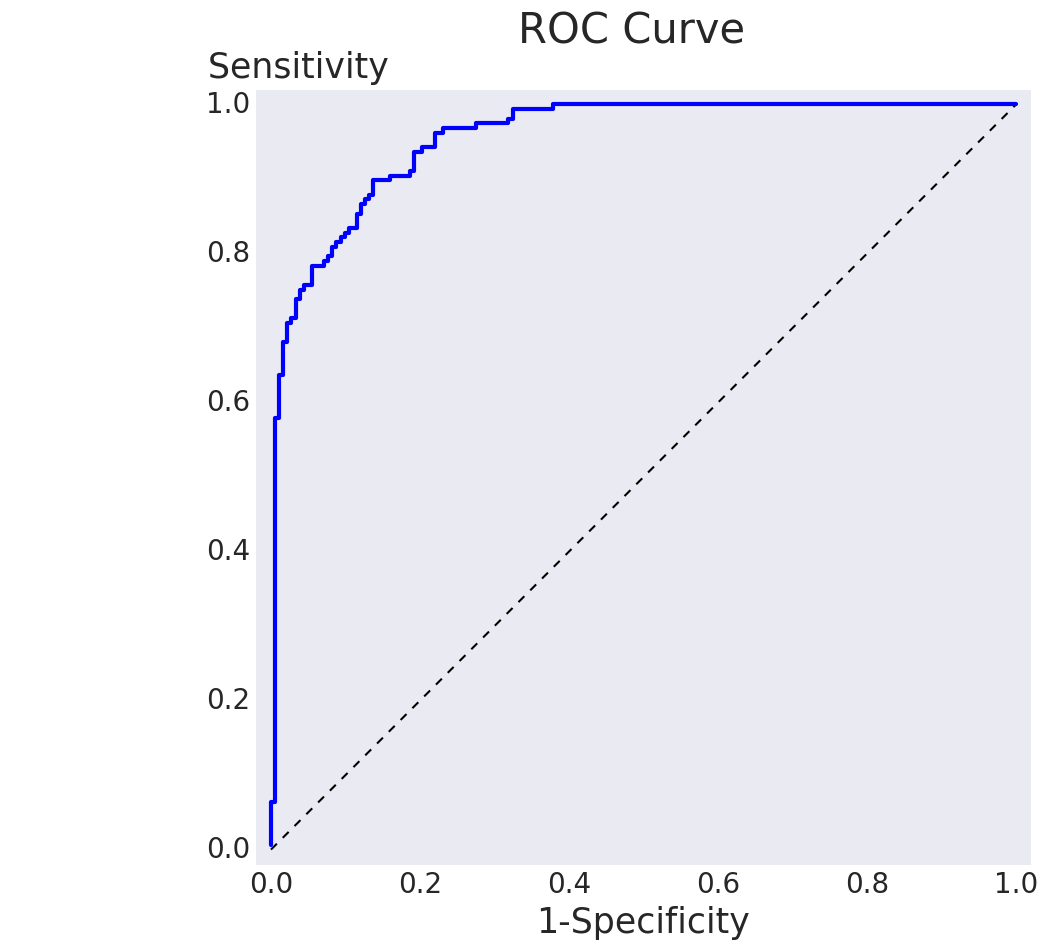

In [14]:
# ROC curve for testing set from orignally labeled dataset
fig, ax = plt.subplots(figsize=(10, 10))
fig.suptitle('ROC Curve', fontsize=30)
ax.plot([0, 1], [0, 1], color='k', linestyle='--', linewidth=1.5)
test_metric_X_1d = [x[1] for x in vgg16_pseudo_Model.predict(test_metric_X)]
curve_dat = roc_curve(test_metric_Y_1d,test_metric_X_1d)
ax.plot(curve_dat[0], curve_dat[1], linewidth=3.0)
print('auc score '+ str(roc_auc_score(test_metric_Y_1d,test_metric_X_1d)))

ax.axis('equal')
ax.set(xlim=[-.02, 1.02], ylim=[-.02, 1.02])
ax.legend(loc='best')
ax.grid(False)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('1-Specificity', fontsize=25)
plt.ylabel('                  Sensitivity', fontsize=25, verticalalignment='top', position=(-5,1.05), rotation='horizontal')
plt.savefig('ROC_curves_full.png')

Confusion matrix, without normalization


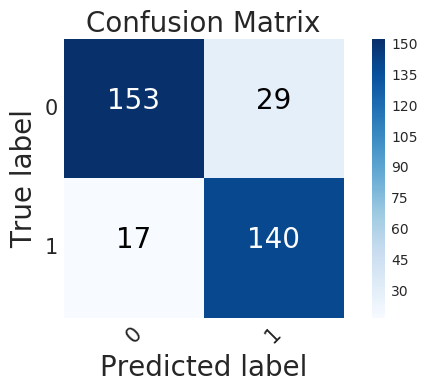

In [47]:
# Helper function for confusion matrix for testing set from orignal labeled dataset
def plot_confusion_matrix_single(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=20,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.title('Confusion Matrix', fontsize=20)

cnf = confusion_matrix(test_metric_Y_1d, vgg16_pseudo_Model.predict_classes(test_metric_X))
plt.figure()
plot_confusion_matrix_single(cnf, classes=np.array([0, 1]))
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

### Create submission file for Kaggle competition

In [15]:
df_validation = pd.read_json('test.json')
Valid_75 = pickle.load(open('HH_HV_Com_validation_75.p', 'rb'))
vgg_Pseudo_dec5 = load_model('models/my_model_ex_aug_params_dec5-1.h5')

In [16]:
yproba_vgg_aug_params_dec5_Pseudo = vgg_Pseudo_dec5.predict(Valid_75)[:, 1].astype(float)

In [19]:
def output_submission(yproba, df_validation):
    submission = pd.DataFrame(yproba)
    df_submission = pd.concat([pd.DataFrame(df_validation['id']), submission], axis=1)
    df_submission = df_submission.rename(columns={0: 'is_iceberg'})
    df_submission.to_csv('Pseudo_Label_VGG16.csv', index=False)

In [20]:
output_submission(yproba_vgg_aug_params_dec5_Pseudo, df_validation)